<a href="https://www.kaggle.com/code/iqmansingh/software-defects-sampling-eda-ensemble?scriptVersionId=145630053" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<div style="display:fill;
           background-color:#14a3c7;
           font-size:110%;
           font-family:'Garamond';
           letter-spacing:0.5px;border-bottom: 5px solid black;">

<img src="https://raw.githubusercontent.com/IqmanS/Machine-Learning-Notebooks/main/software_defects/banner.jpg">
<H1 style="padding: 20px;color:black;font-weight:700;">💻 Binary Classification with a Software Defects Dataset</H1>
</div>


In [129]:
import numpy as np 
import pandas as pd 
import warnings
warnings.filterwarnings("ignore")
import os
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("dark") # Theme for plots as Dark
sns.set_palette("rocket")
# sns.color_palette("flare")
from catboost import CatBoostClassifier, Pool
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Importing Dataset

In [130]:
train_data = pd.read_csv("/kaggle/input/playground-series-s3e23/train.csv",index_col="id")
test_data = pd.read_csv("/kaggle/input/playground-series-s3e23/test.csv",index_col="id")
orig_data = pd.read_csv("/kaggle/input/software-defect-prediction/jm1.csv")
train_data.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [131]:
for i in orig_data.select_dtypes("object").columns:
    orig_data[i].replace({"?":np.NaN},inplace=True)
    orig_data[i] = orig_data[i].astype(float)

In [132]:
train_data = pd.concat((train_data,orig_data))

# Removing Outliers

In [133]:
metrics = train_data.describe()
for i in train_data.columns:
    if i!= "defects":
        Q1 = metrics[i]["25%"]
        Q3 = metrics[i]["75%"]  
        IQR = Q3-Q1
        upper = Q3+IQR*1.5
        lower = Q1-IQR*1.5
        train_data[i][train_data[i]>upper] = np.NaN
        train_data[i][train_data[i]<lower] = np.NaN
        
train_data.dropna(inplace=True)
train_data.reset_index(drop=True,inplace=True)

In [134]:
train_data.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000,...,69277.000000,69277.000000,69277.000000,69277.000000,69277.0,69277.000000,69277.000000,69277.000000,69277.000000,69277.000000
mean,20.209146,3.194639,1.542821,2.252118,51.462679,244.032813,0.118795,9.825852,22.102014,3416.292618,...,189.814112,13.180305,0.169089,2.309973,0.0,10.636243,11.084386,30.758794,20.692308,5.341686
std,12.396568,1.984202,1.221146,1.288837,37.227555,203.182660,0.070471,6.078223,11.296604,4469.512421,...,248.271722,9.141857,0.480212,1.990964,0.0,4.446329,6.612815,22.119556,15.488771,3.916235
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11.000000,2.000000,1.000000,1.000000,25.000000,96.340000,0.070000,5.630000,14.830000,578.020000,...,32.110000,7.000000,0.000000,1.000000,0.0,8.000000,6.000000,15.000000,10.000000,3.000000
50%,17.000000,3.000000,1.000000,2.000000,41.000000,182.660000,0.110000,8.550000,20.770000,1534.730000,...,85.280000,11.000000,0.000000,2.000000,0.0,11.000000,10.000000,25.000000,16.000000,5.000000
75%,26.000000,4.000000,1.000000,3.000000,69.000000,330.690000,0.160000,13.000000,28.350000,4291.730000,...,238.430000,18.000000,0.000000,3.000000,0.0,13.000000,15.000000,41.000000,28.000000,7.000000
max,85.000000,12.000000,6.000000,8.000000,220.000000,1274.110000,0.310000,37.300000,63.340000,24823.100000,...,1379.060000,56.000000,2.000000,11.000000,0.0,28.000000,41.000000,142.000000,99.000000,23.000000


# Data Viz 

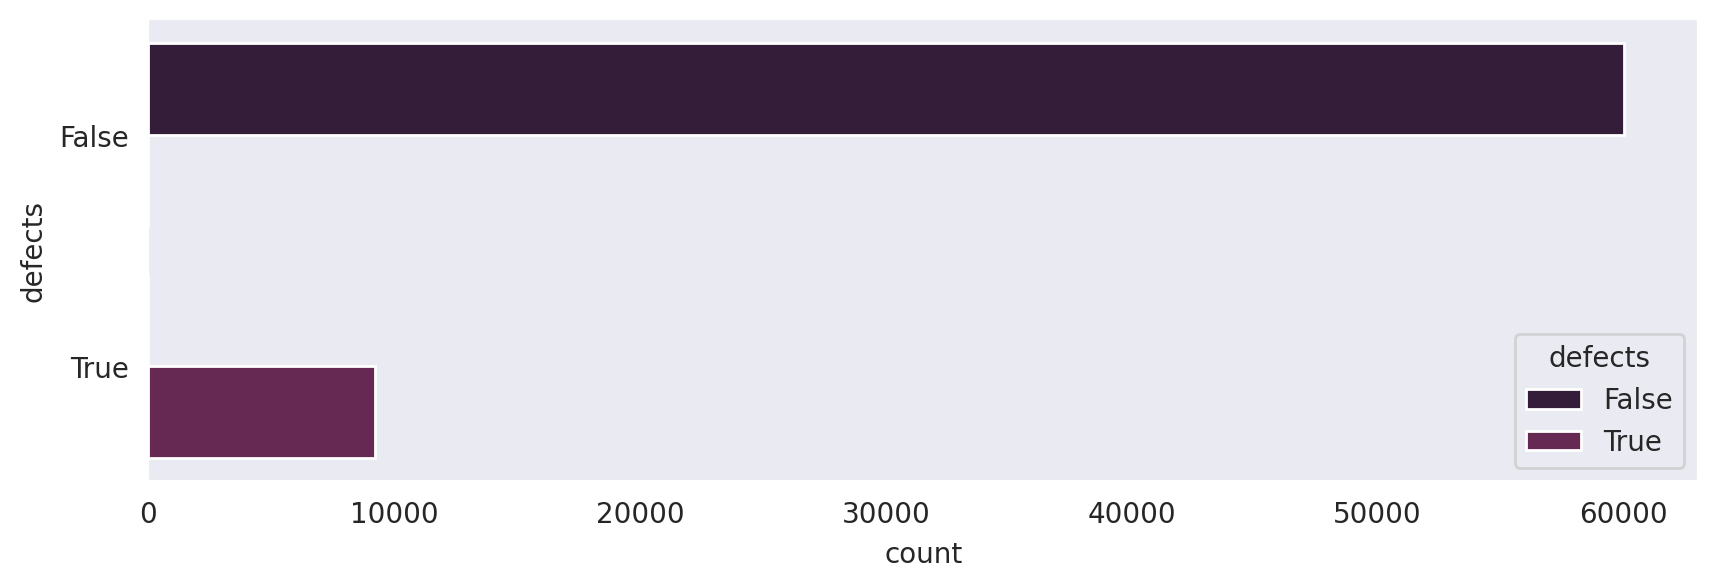

In [135]:
plt.figure(figsize=(10,3),dpi=200)
sns.countplot(train_data, y="defects",hue="defects");

In [136]:
fig,axes = plt.subplots(21,2,figsize=(15, 60),dpi=300)

for ind,col in enumerate(train_data.select_dtypes("float64").columns):
    plt.subplot(21,2,2*ind+1)
    sns.histplot(train_data[col],bins=15,kde=True)
    plt.gca().set_title(col)
    
    plt.subplot(21,2,2*ind+2)
    sns.boxplot(train_data[col],orient="h",palette="flare")
    plt.gca().set_title(col)
    
fig.tight_layout()
plt.show()

# Baseline

In [137]:
cols = [i for i in train_data.columns if i!="defects"]
seed = np.random.seed(6)

X = train_data[cols]
y = train_data["defects"]

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25,random_state=seed)

In [138]:
history = pd.DataFrame()
def plotImportance(model):
    history["cols"] = X_test.columns
    history["imp"] = model.feature_importances_
    history.sort_values("imp",inplace=True)
    history.reset_index(drop=True)
    plt.figure(figsize=(15,6))
    sns.barplot(x=history["imp"],y=history["cols"],palette="rocket");
#     return history.cols[-10:]

In [139]:
rfmodel = RandomForestClassifier(random_state=seed)
rfmodel.fit(X,y)
print("CV score of RF is ",cross_val_score(rfmodel,X,y,cv=3, scoring = 'roc_auc').mean())

xgbmodel = XGBClassifier(random_state=seed)
xgbmodel.fit(X,y)
print("CV score of XGB is ",cross_val_score(xgbmodel,X,y,cv=3, scoring = 'roc_auc').mean())

lgbmmodel = LGBMClassifier(random_state=seed)
lgbmmodel.fit(X,y)
print("CV score of LGBM is ",cross_val_score(lgbmmodel,X,y,cv=3, scoring = 'roc_auc').mean())

vcmodel = VotingClassifier([("rf",rfmodel),("xgb",xgbmodel),("lgbm",lgbmmodel)],voting="soft")
vcmodel.fit(X,y)
print("CV score of VC is ",cross_val_score(vcmodel,X,y,cv=3, scoring = 'roc_auc').mean())

CV score of RF is  0.6492326799026469
CV score of XGB is  0.6713420045311063
CV score of LGBM is  0.6927977586591268
CV score of VC is  0.6817138828911786


### Creating a Baseline 'submission.csv'

In [140]:
preds = vcmodel.predict_proba(test_data)

submission = pd.DataFrame()
submission["id"] = test_data.index
submission["defects"] = preds[:,1]
submission.to_csv("submission.csv",header=True,index=False)

# Sampling

### Undersampling

In [141]:
undersample1 = RandomUnderSampler(sampling_strategy='majority')
undersample2 = RandomUnderSampler(sampling_strategy=0.5)

X_under1, y_under1 = undersample1.fit_resample(X_train, y_train)
X_under2, y_under2 = undersample2.fit_resample(X_train, y_train)

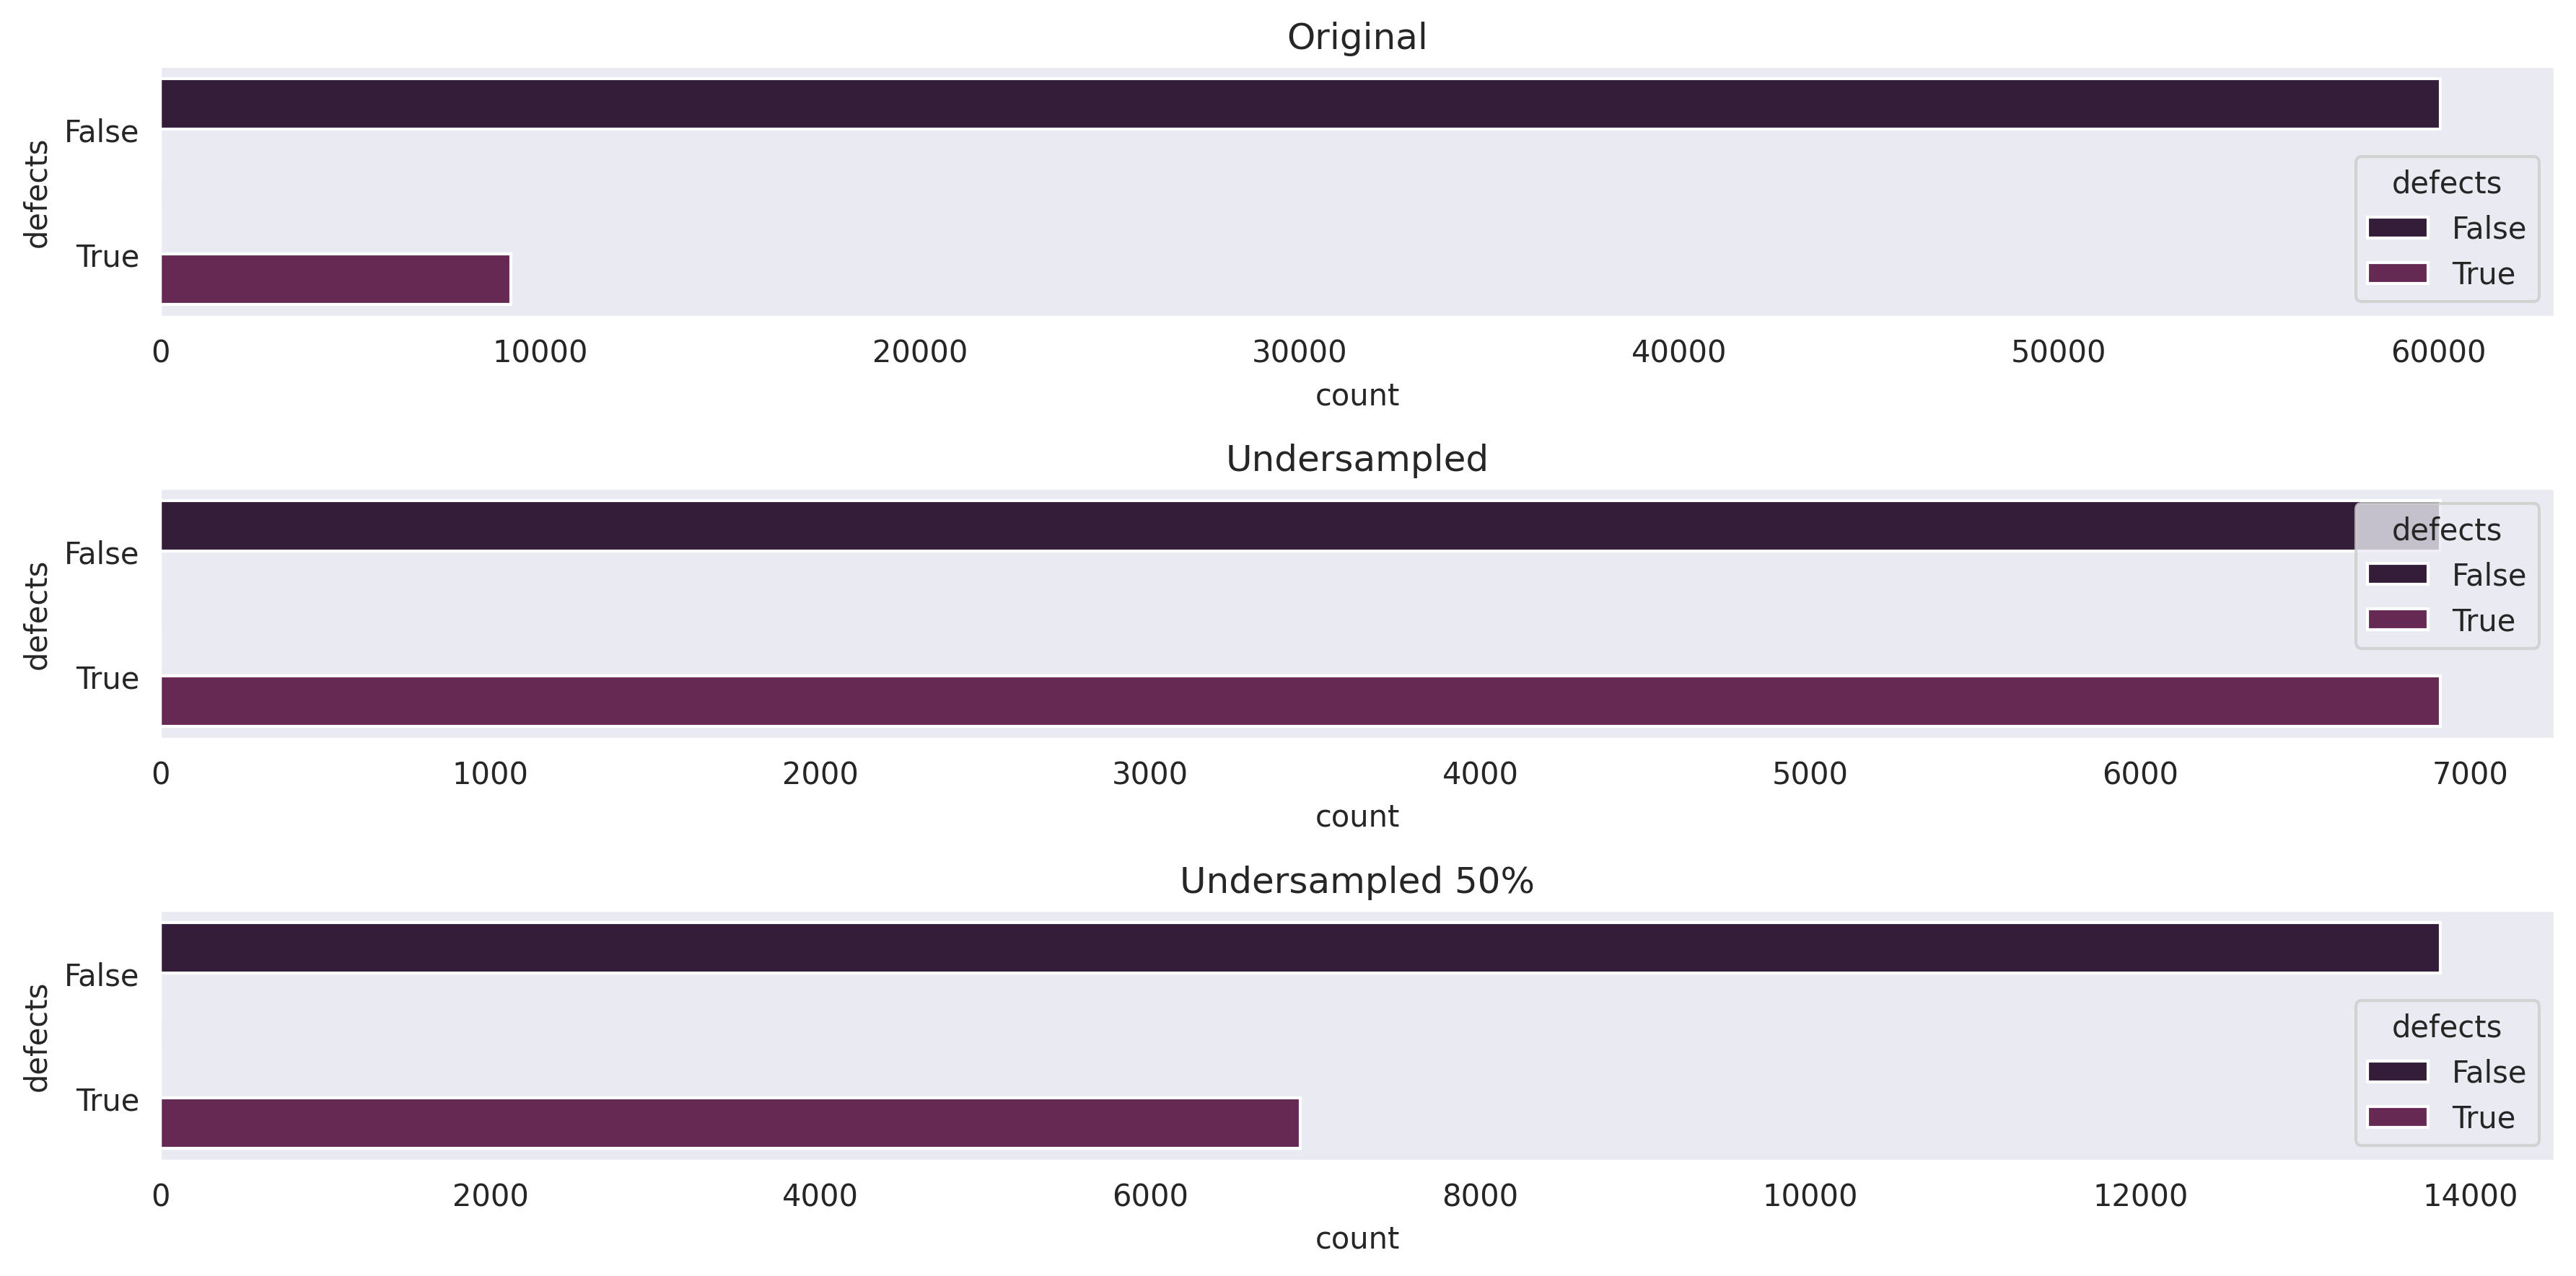

In [142]:
fig,axes = plt.subplots(3,1,figsize=(12, 6),dpi=300)

plt.subplot(3,1,1)
sns.countplot(train_data,y="defects",hue="defects");
plt.gca().set_title("Original")
plt.subplot(3,1,2)
sns.countplot(pd.DataFrame(y_under1), y="defects",hue="defects");
plt.gca().set_title("Undersampled")
plt.subplot(3,1,3)
sns.countplot(pd.DataFrame(y_under2), y="defects",hue="defects");
plt.gca().set_title("Undersampled 50%")

fig.tight_layout()
plt.show()

ROC Score for Undersampling 100%: 0.6770091810344827
ROC Score for Undersampling 50%: 0.6824488074712645


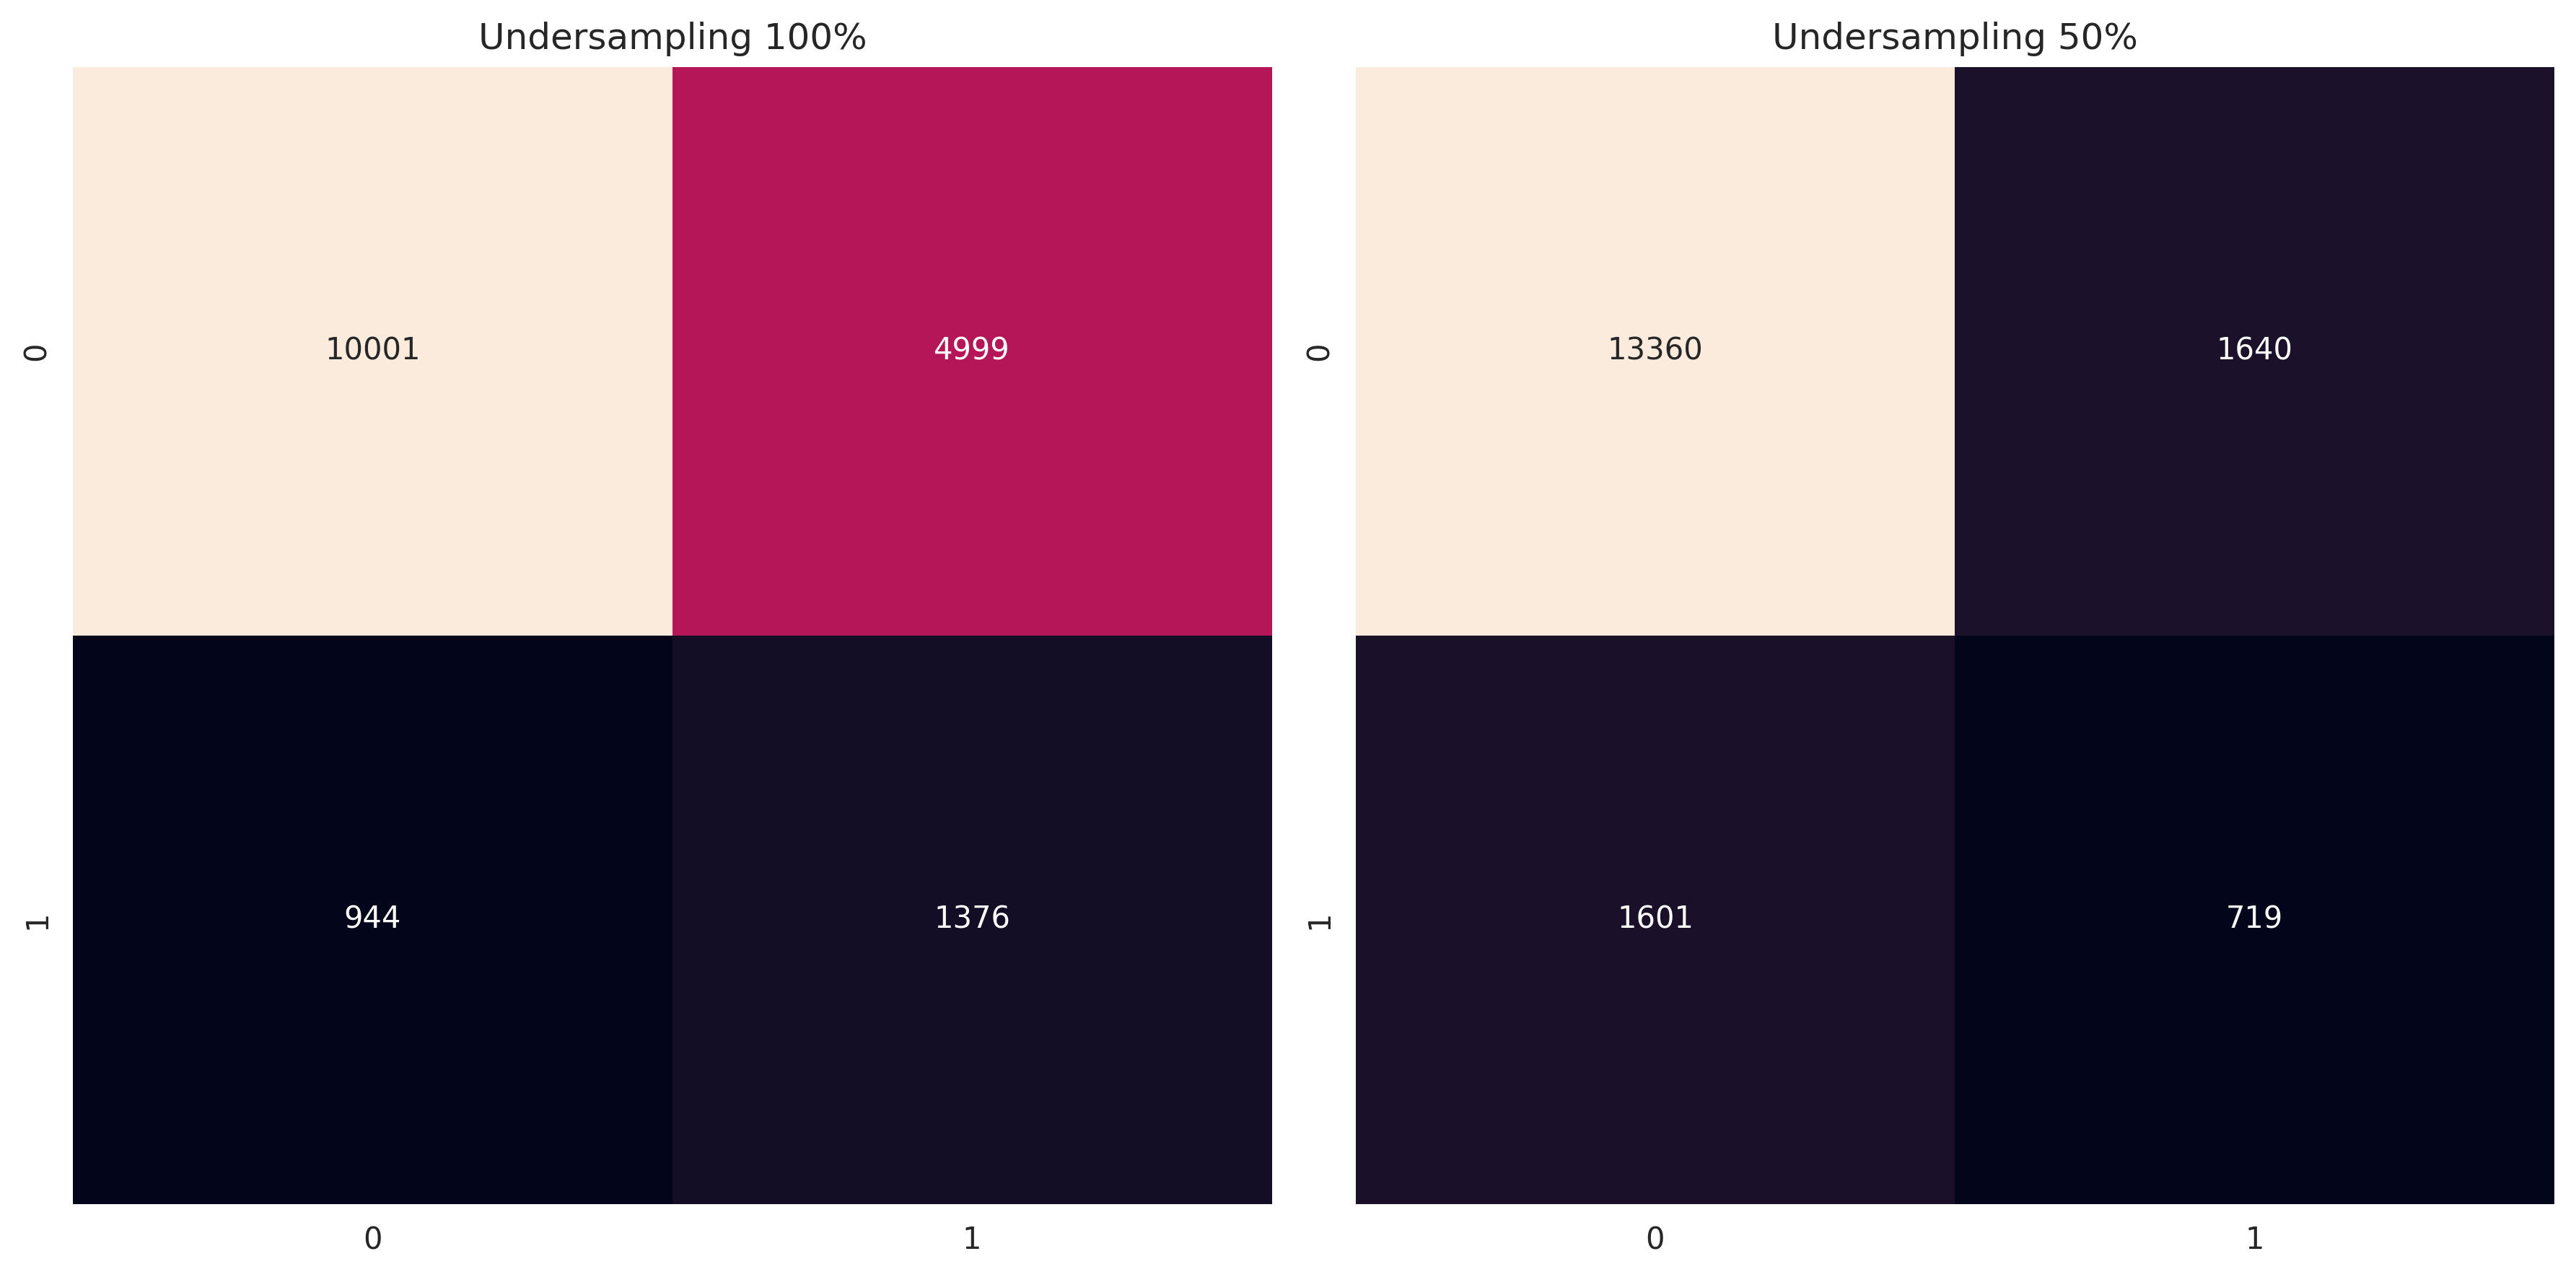

In [143]:
fig,axes = plt.subplots(1,2,figsize=(12, 6),dpi=300)

vcmodel.fit(X_under1,y_under1)
print("ROC Score for Undersampling 100%:", roc_auc_score(y_test,vcmodel.predict_proba(X_test)[:,1]))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,vcmodel.predict(X_test)),annot=True,fmt=".5g",cbar=False )
plt.gca().set_title("Undersampling 100%")


vcmodel.fit(X_under2,y_under2)
print("ROC Score for Undersampling 50%:", roc_auc_score(y_test,vcmodel.predict_proba(X_test)[:,1]))
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,vcmodel.predict(X_test)),annot=True,fmt=".5g",cbar=False );
plt.gca().set_title("Undersampling 50%");

fig.tight_layout()
plt.show();

In [144]:
# vcmodel.fit(X_under2,y_under2)
# preds = vcmodel.predict_proba(test_data)

# submission = pd.DataFrame()
# submission["id"] = test_data.index
# submission["defects"] = preds[:,1]
# submission.to_csv("submission-undersampled2.csv",header=True,index=False)

### Oversampling

In [145]:
oversample1 = RandomOverSampler(sampling_strategy='minority')
oversample2 = RandomOverSampler(sampling_strategy=0.5)

X_over1, y_over1 = oversample1.fit_resample(X_train, y_train)
X_over2, y_over2 = oversample2.fit_resample(X_train, y_train)

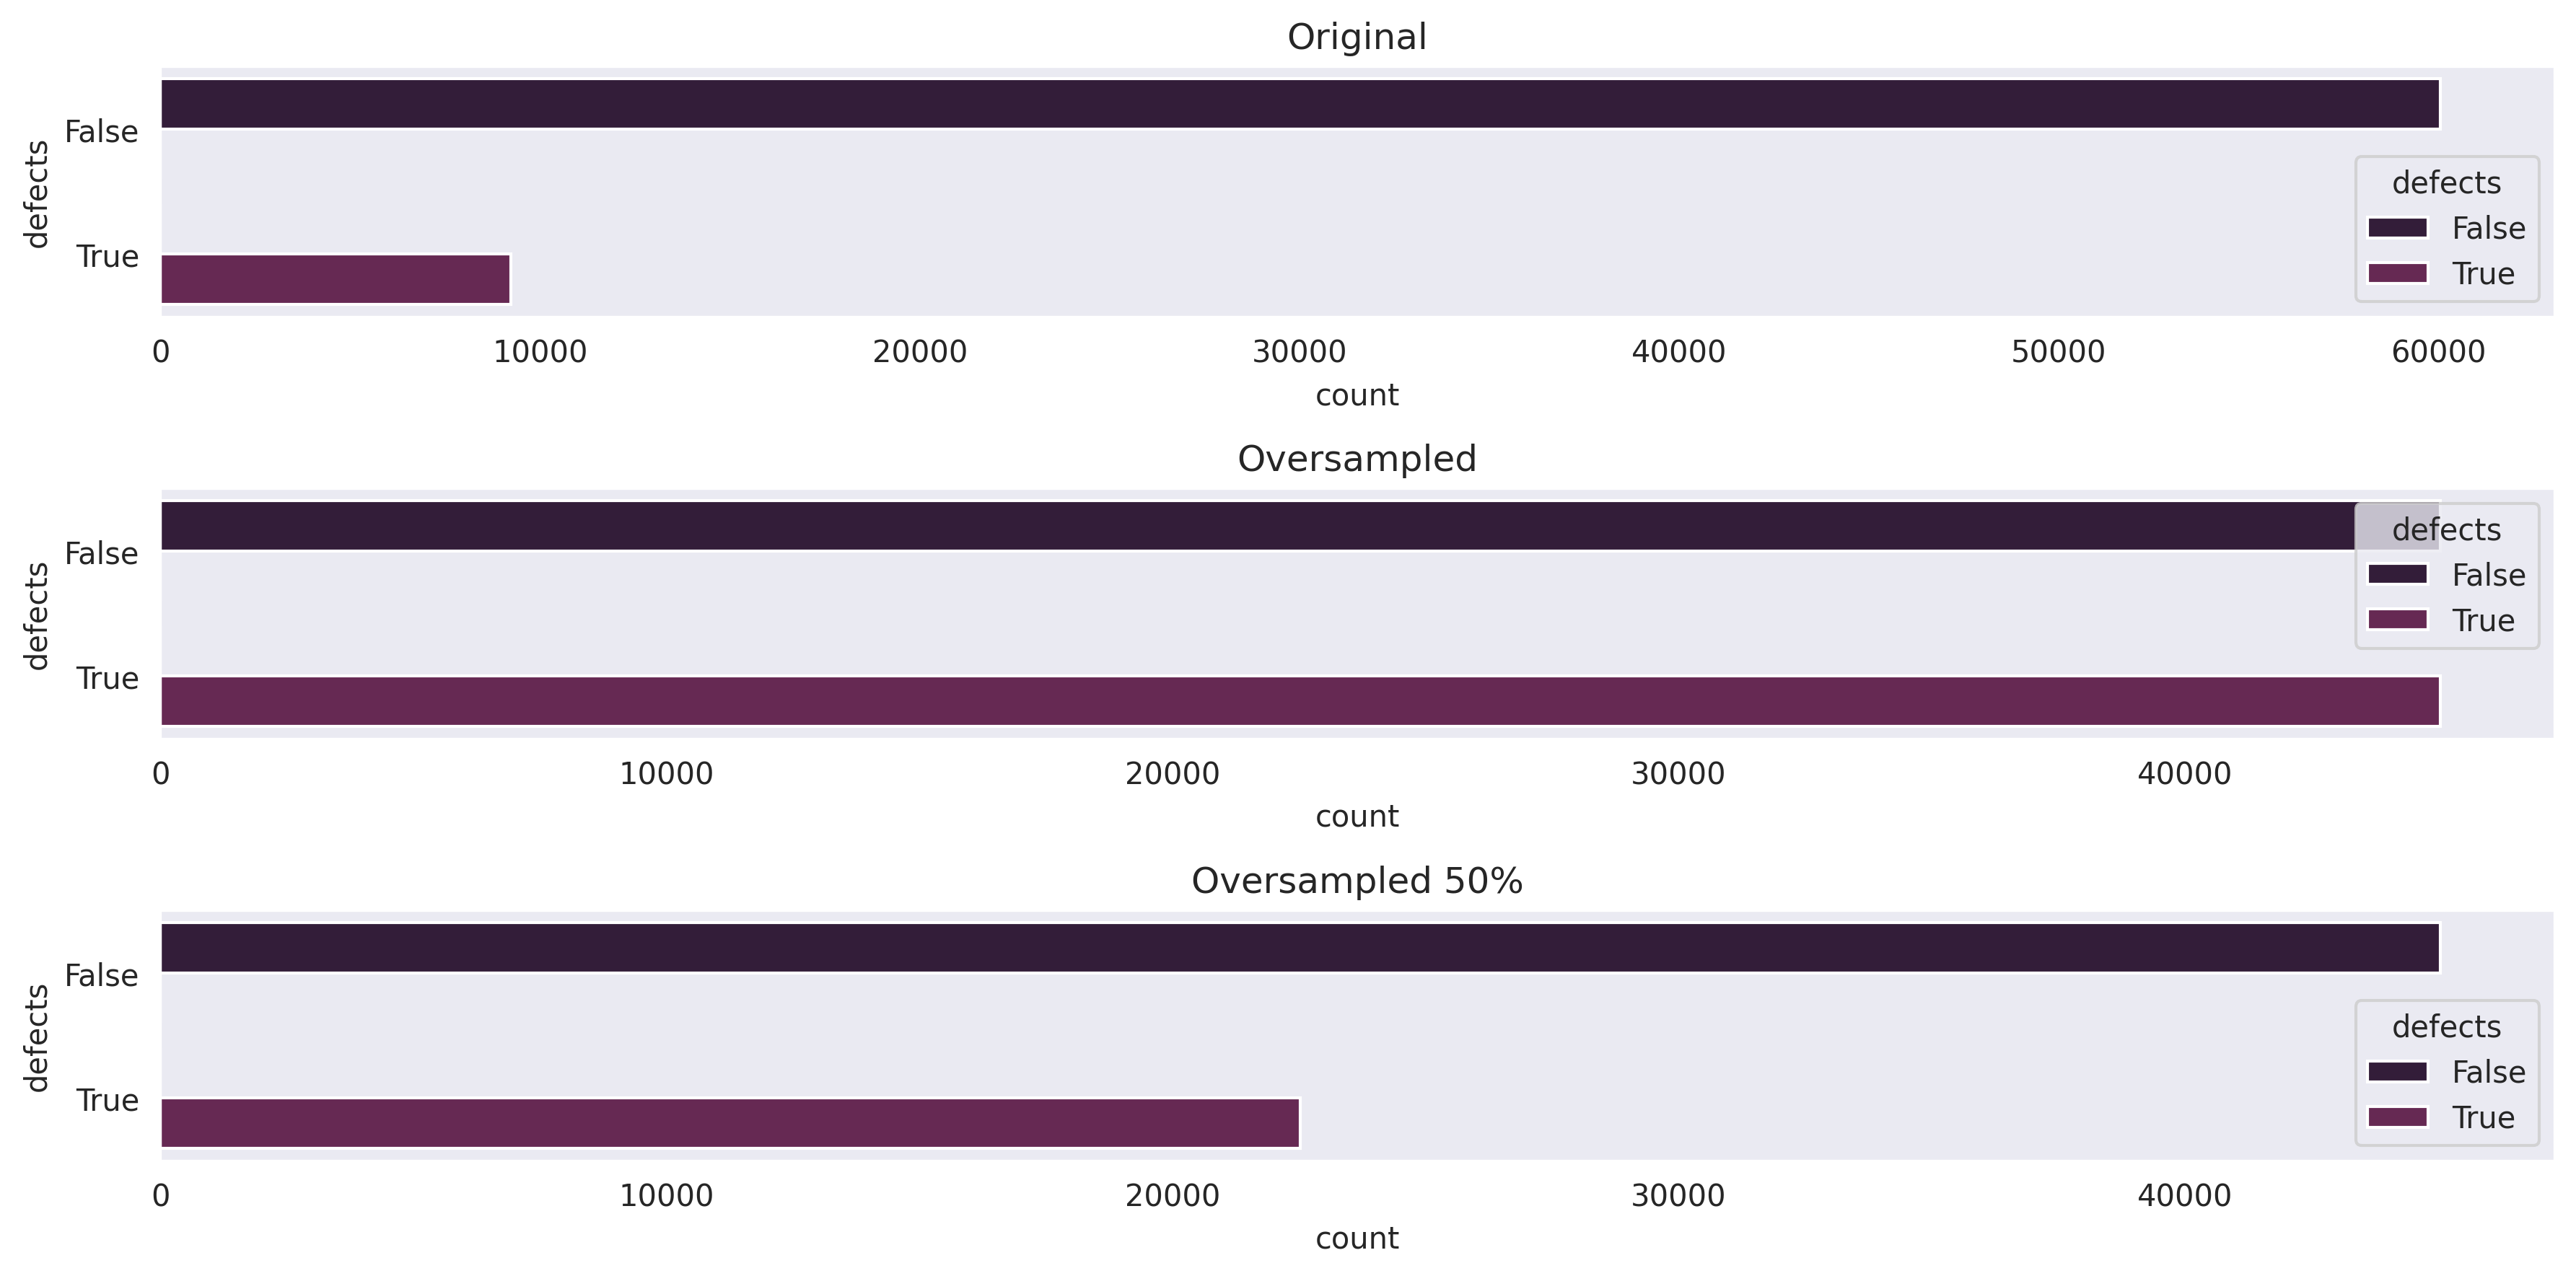

In [146]:
fig,axes = plt.subplots(3,1,figsize=(12, 6),dpi=300)

plt.subplot(3,1,1)
sns.countplot(train_data,y="defects",hue="defects");
plt.gca().set_title("Original")
plt.subplot(3,1,2)
sns.countplot(pd.DataFrame(y_over1), y="defects",hue="defects");
plt.gca().set_title("Oversampled")
plt.subplot(3,1,3)
sns.countplot(pd.DataFrame(y_over2), y="defects",hue="defects");
plt.gca().set_title("Oversampled 50%")

fig.tight_layout()
plt.show()

ROC Score for Oversampling 100%: 0.6775962931034483
ROC Score for Oversampling 50%: 0.6797293103448276


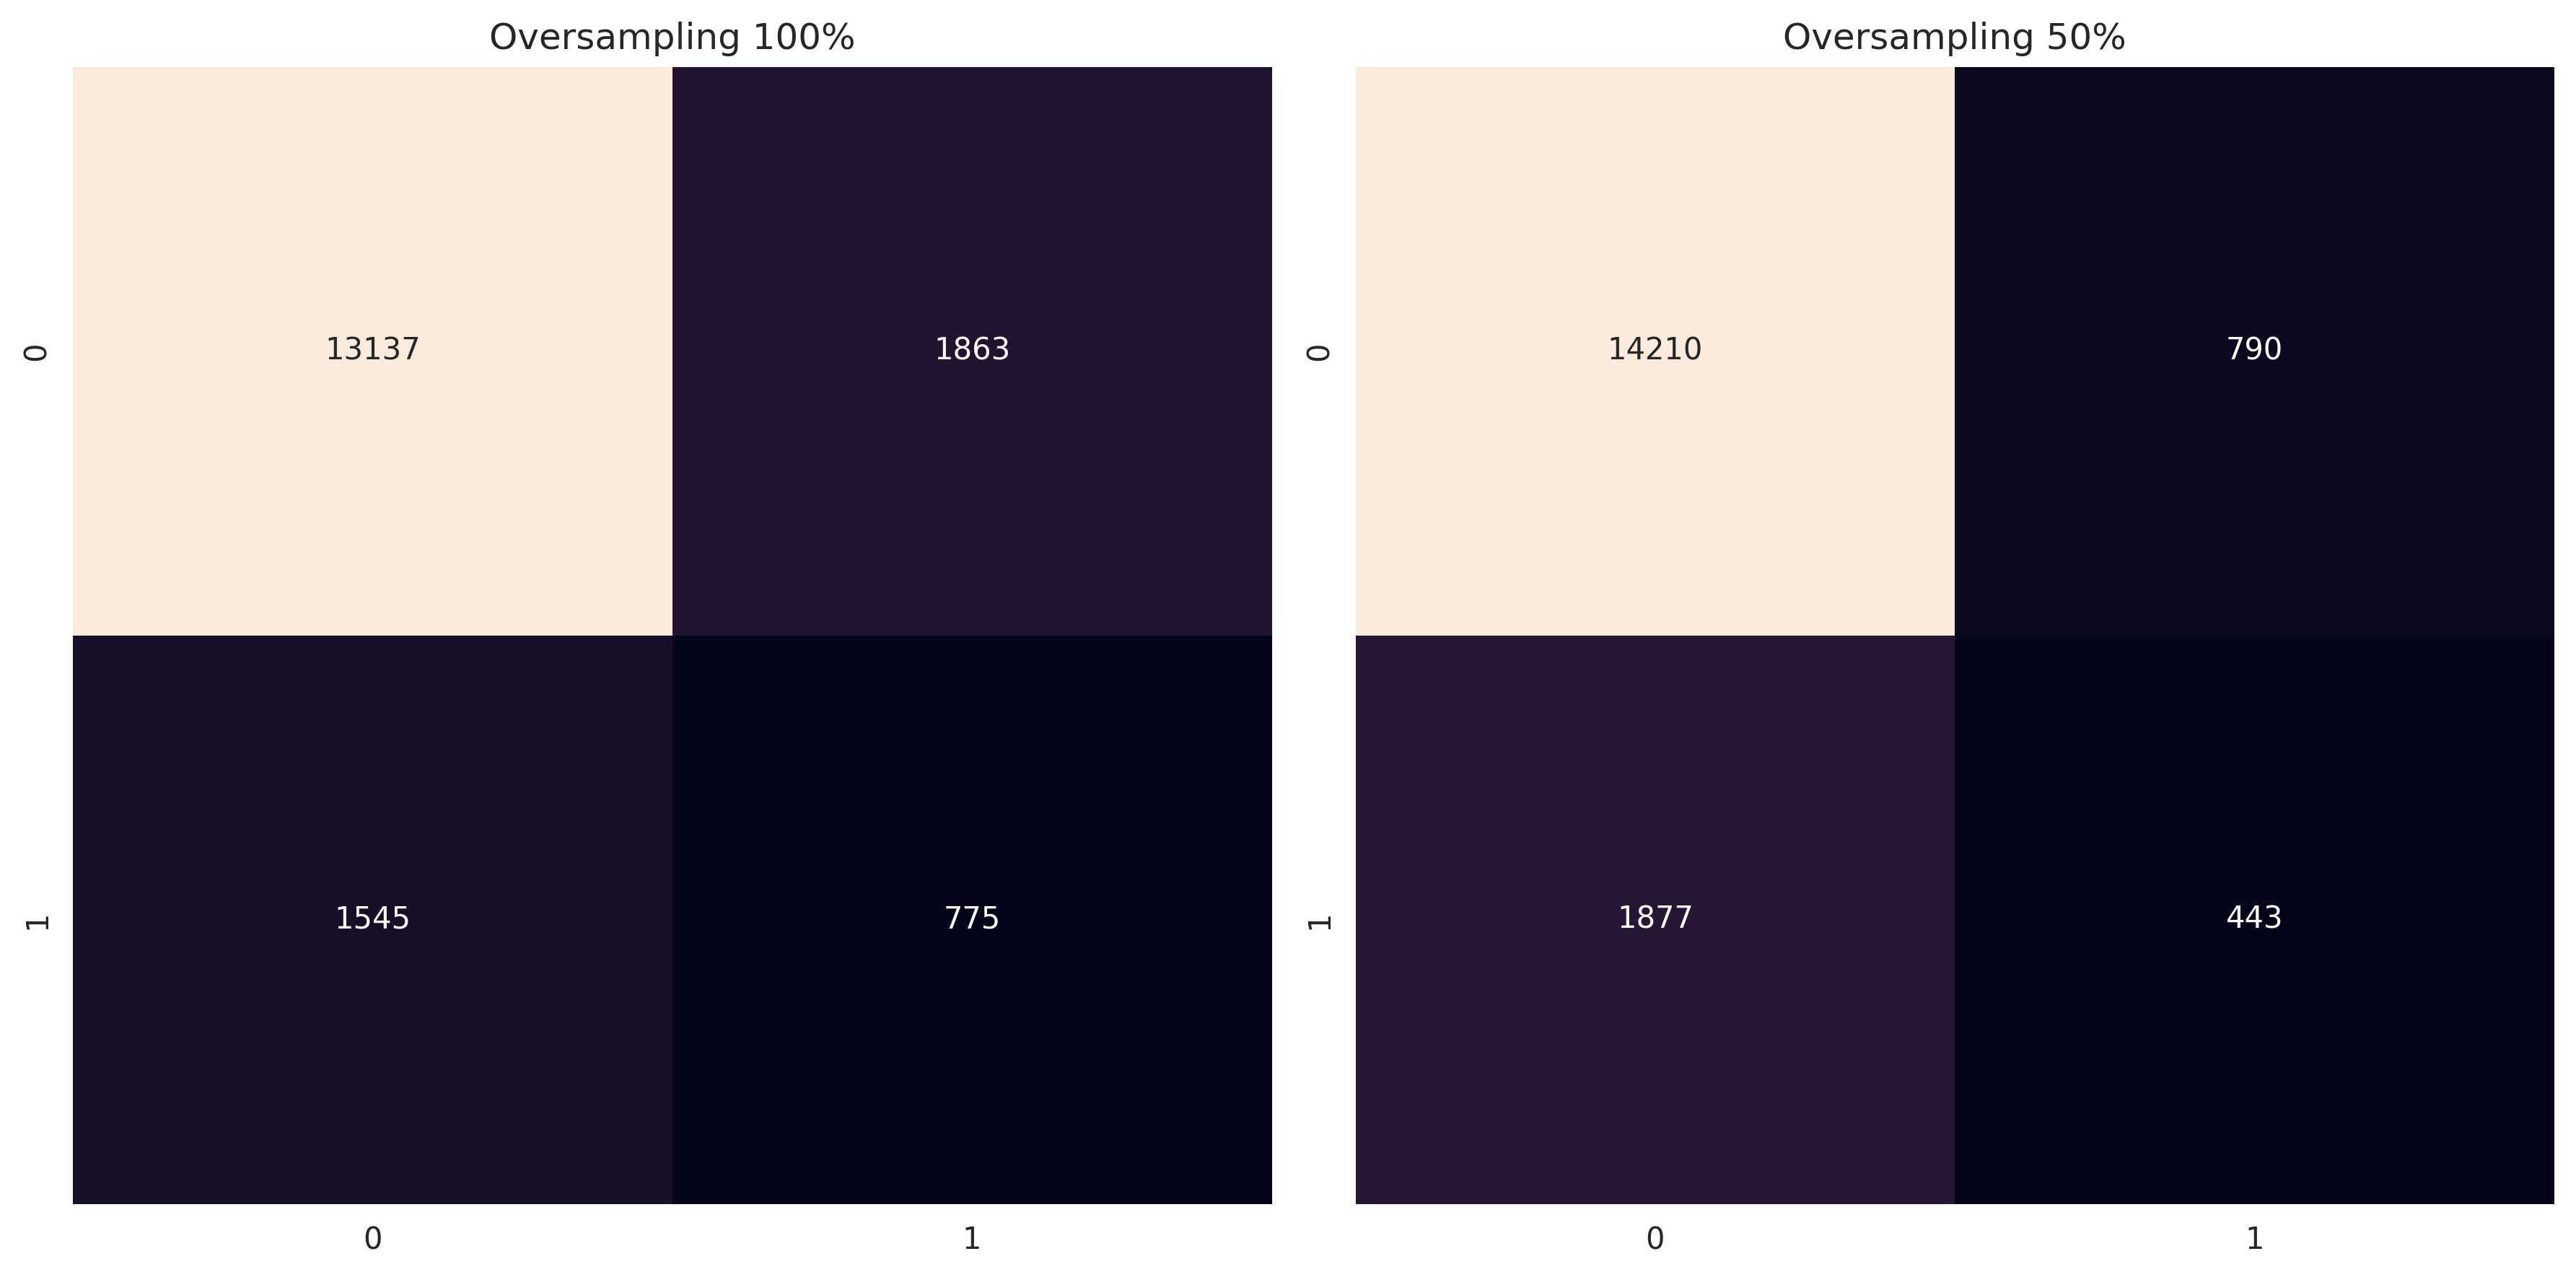

In [147]:
fig,axes = plt.subplots(1,2,figsize=(12, 6),dpi=300)

vcmodel.fit(X_over1,y_over1)
print("ROC Score for Oversampling 100%:", roc_auc_score(y_test,vcmodel.predict_proba(X_test)[:,1]))
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test,vcmodel.predict(X_test)),annot=True,fmt=".5g",cbar=False )
plt.gca().set_title("Oversampling 100%")

vcmodel.fit(X_over2,y_over2)
print("ROC Score for Oversampling 50%:", roc_auc_score(y_test,vcmodel.predict_proba(X_test)[:,1]))
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test,vcmodel.predict(X_test)),annot=True,fmt=".5g",cbar=False );
plt.gca().set_title("Oversampling 50%")

fig.tight_layout()
plt.show()

In [148]:
# vcmodel.fit(X_over2,y_over2)
# preds = vcmodel.predict_proba(test_data)

# submission = pd.DataFrame()
# submission["id"] = test_data.index
# submission["defects"] = preds[:,1]
# submission.to_csv("submission-oversampled2.csv",header=True,index=False)

# Plotting Feature Importance

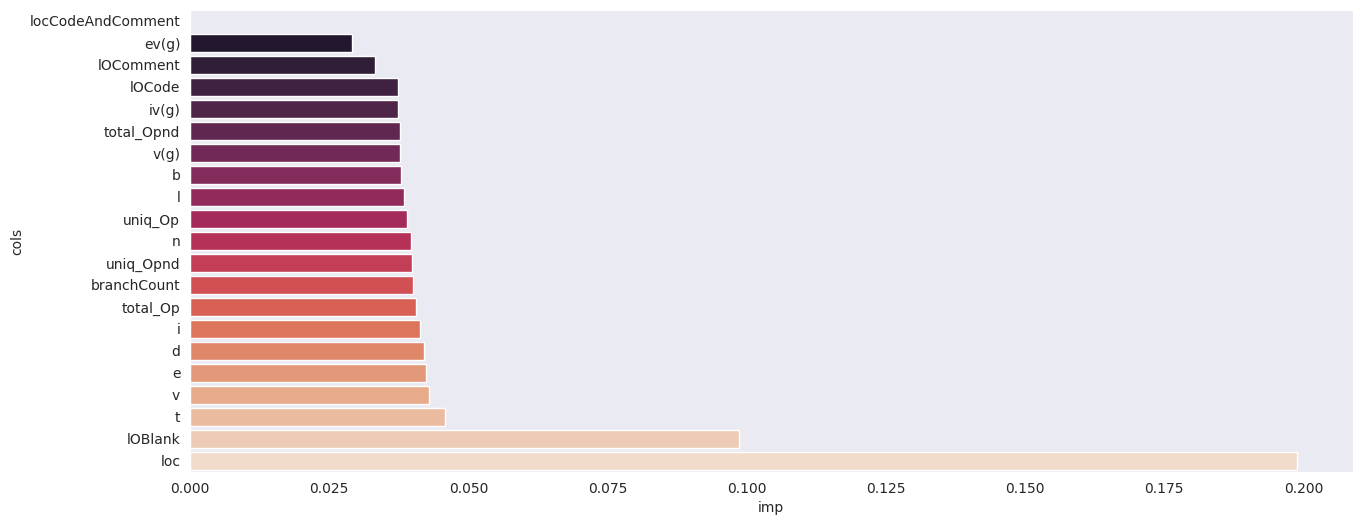

In [149]:
plotImportance(xgbmodel)